In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath 
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def split_cell(df):
    df_charge = df[df['type'] == 'charge']
    df_discharge = df[df['type'] == 'discharge']
    df_impedance = df[df['type'] == 'impedance']

    df_charge = df_charge.reset_index(drop=True)  # Drops old index, new one is not saved in CSV
    df_discharge = df_discharge.reset_index(drop=True)
    df_impedance = df_impedance.reset_index(drop=True)
    
    return df_charge,df_discharge,df_impedance

In [4]:
def expand(charge,discharge):
    df_charge = charge.join(pd.json_normalize(charge['data']))
    df_discharge = discharge.join(pd.json_normalize(discharge['data']))

    df_charge["cycle"] = range(1, len(df_charge) + 1)
    df_discharge["cycle"] = range(1, len(df_discharge) + 1)
    
    # Drop the original 'data' column as it's no longer needed
    df_charge.drop(columns=['data'], inplace=True)
    df_discharge.drop(columns=['data'], inplace=True)
    return df_charge,df_discharge

In [5]:
def process_charge_data(df_charge):
    processed_rows = []

    for _, row in df_charge.iterrows():
        time = np.array(row["Time"])
        voltage = np.array(row["Voltage_measured"])

        charge_time = time[-1] - time[0]
        min_voltage_charge = np.min(voltage)

        processed_rows.append({
            "battery_id": row["battery_id"],
            "cycle": row["cycle"],
            "charge_time": charge_time,
            "min_voltage_charge": min_voltage_charge
        })

    return pd.DataFrame(processed_rows)


In [6]:
def process_discharge_data(df_discharge):
    processed_rows = []

    for _, row in df_discharge.iterrows():
        time = np.array(row["Time"])
        voltage = np.array(row["Voltage_measured"])

        discharge_time = time[-1] - time[0]
        max_voltage_discharge = np.max(voltage)

        processed_rows.append({
            "battery_id": row["battery_id"],
            "cycle": row["cycle"],
            "Capacity": row["Capacity"],
            "discharge_time": discharge_time,
            "max_voltage_discharge": max_voltage_discharge
        })

    return pd.DataFrame(processed_rows)


In [7]:
def preprocess_data(df):
    charge,discharge,_=split_cell(df)
    charge,discharge=expand(charge,discharge)
    
    df_charge_processed = process_charge_data(charge)
    df_discharge_processed = process_discharge_data(discharge)    

    return df_charge_processed,df_discharge_processed

In [8]:
def merge_cycles(charge, discharge):
    # Merge on both battery_id_x and cycle to ensure proper alignment
    df_merged = pd.merge(charge, discharge, on=["battery_id", "cycle"], how="inner")
    return df_merged


In [9]:
import os
import pickle
import pandas as pd

data_folder = "../Dataset/data"
battery_ids=os.listdir(data_folder)
processed_dfs = []

for battery_id in battery_ids:
    file_path = os.path.join(data_folder, f"{battery_id}")
    
    with open(file_path, "rb") as f:
        battery_data = pickle.load(f)

    battery_data['battery_id'] = battery_id[:5]
    
    df_charge, df_discharge = preprocess_data(battery_data)
    df_charge['battery_id'] = battery_id[:5]
    df_discharge['battery_id'] = battery_id[:5]

    # Merge charge & discharge
    df_processed = merge_cycles(df_charge, df_discharge)

    # Feature engineering
    df_processed['Total time'] = df_processed['charge_time'] + df_processed['discharge_time']
    
    initial_capacity = df_processed['Capacity'].iloc[0]
    df_processed['initial_capacity'] = initial_capacity
    df_processed['current_capacity_percent'] = (df_processed['Capacity'] / initial_capacity) * 100
    df_processed['battery_fading_percent'] = 100 - df_processed['current_capacity_percent']
    
    last_cycle = df_processed['cycle'].max()
    df_processed['RUL'] = last_cycle - df_processed['cycle']
    
    # Append to list
    processed_dfs.append(df_processed)

# Combine all batteries
df_all = pd.concat(processed_dfs, ignore_index=True)



In [10]:
df_all

,battery_id,cycle,charge_time,min_voltage_charge,Capacity,discharge_time,max_voltage_discharge,Total time,initial_capacity,current_capacity_percent,battery_fading_percent,RUL
0,B0005,1,7597.875,3.479394,1.856487,3690.234,4.191492,11288.109,1.856487,100.0,0.0,167
1,B0005,2,10516.000,3.001951,1.846327,3672.344,4.189773,14188.344,1.856487,99.452721,0.547279,166
2,B0005,3,10484.547,3.035879,1.835349,3651.641,4.188187,14136.188,1.856487,98.861386,1.138614,165
3,B0005,4,10397.890,3.066145,1.835263,3631.563,4.188461,14029.453,1.856487,98.856718,1.143282,164
4,B0005,5,10495.203,3.063766,1.834646,3629.172,4.188299,14124.375,1.856487,98.823482,1.176518,163
...,...,...,...,...,...,...,...,...,...,...,...,...
2787,B0056,98,10803.219,3.731536,1.130219,2345.000,4.181822,13148.219,0.785278,143.925969,-43.925969,4
2788,B0056,99,10803.406,3.733652,1.125872,2363.047,4.181950,13166.453,0.785278,143.372381,-43.372381,3
2789,B0056,100,10802.032,3.771261,1.143011,2316.687,4.181791,13118.719,0.785278,145.554906,-45.554906,2
2790,B0056,101,10804.016,3.728542,1.137273,2322.000,4.173014,13126.016,0.785278,144.824254,-44.824254,1


In [11]:
from sklearn.preprocessing import LabelEncoder
df_all['battery_id_encoded'] = LabelEncoder().fit_transform(df_all['battery_id'])

In [12]:
df_all

,battery_id,cycle,charge_time,min_voltage_charge,Capacity,discharge_time,max_voltage_discharge,Total time,initial_capacity,current_capacity_percent,battery_fading_percent,RUL,battery_id_encoded
0,B0005,1,7597.875,3.479394,1.856487,3690.234,4.191492,11288.109,1.856487,100.0,0.0,167,0
1,B0005,2,10516.000,3.001951,1.846327,3672.344,4.189773,14188.344,1.856487,99.452721,0.547279,166,0
2,B0005,3,10484.547,3.035879,1.835349,3651.641,4.188187,14136.188,1.856487,98.861386,1.138614,165,0
3,B0005,4,10397.890,3.066145,1.835263,3631.563,4.188461,14029.453,1.856487,98.856718,1.143282,164,0
4,B0005,5,10495.203,3.063766,1.834646,3629.172,4.188299,14124.375,1.856487,98.823482,1.176518,163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,B0056,98,10803.219,3.731536,1.130219,2345.000,4.181822,13148.219,0.785278,143.925969,-43.925969,4,33
2788,B0056,99,10803.406,3.733652,1.125872,2363.047,4.181950,13166.453,0.785278,143.372381,-43.372381,3,33
2789,B0056,100,10802.032,3.771261,1.143011,2316.687,4.181791,13118.719,0.785278,145.554906,-45.554906,2,33
2790,B0056,101,10804.016,3.728542,1.137273,2322.000,4.173014,13126.016,0.785278,144.824254,-44.824254,1,33


In [13]:
import numpy as np
import pandas as pd

def fix_capacity(val):
    if isinstance(val, np.ndarray):
        return val.item() if val.size == 1 else np.nan  # get scalar if 1-element array
    elif isinstance(val, (float, int)):
        return val
    else:
        return np.nan

df_all["Capacity"] = df_all["Capacity"].apply(fix_capacity)


In [14]:
print(df_all["Capacity"].dtype)  # should be float64

float64


In [15]:
import pandas as pd

# Example for one column
df_all['current_capacity_percent'] = pd.to_numeric(df_all['current_capacity_percent'], errors='coerce')
df_all['battery_fading_percent'] = pd.to_numeric(df_all['battery_fading_percent'], errors='coerce')
df_all.fillna(0, inplace=True)

In [16]:
# Feature columns
features = ['battery_id_encoded','initial_capacity', 'Capacity', 'current_capacity_percent',
            'battery_fading_percent', 'cycle','charge_time','min_voltage_charge','discharge_time','max_voltage_discharge','Total time']
target = 'RUL'

Splitting Data Into training and testing data

In [17]:
X = df_all[features]
y = df_all[target]

In [18]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


In [21]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [22]:
best_rf = grid_search.best_estimator_

# Predict & evaluate
rf_preds = best_rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

print(f"Optimized Random Forest R² Score: {rf_r2:.3f}")
print(f"Optimized Random Forest MSE: {rf_mse:.3f}")
print("Best Parameters:", grid_search.best_params_)


Optimized Random Forest R² Score: 0.982
Optimized Random Forest MSE: 37.286
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


                     Feature  Importance
8             discharge_time    0.293666
10                Total time    0.163668
5                      cycle    0.103216
2                   Capacity    0.099776
0         battery_id_encoded    0.091116
3   current_capacity_percent    0.059222
4     battery_fading_percent    0.057828
6                charge_time    0.047756
1           initial_capacity    0.039149
7         min_voltage_charge    0.034668
9      max_voltage_discharge    0.009936


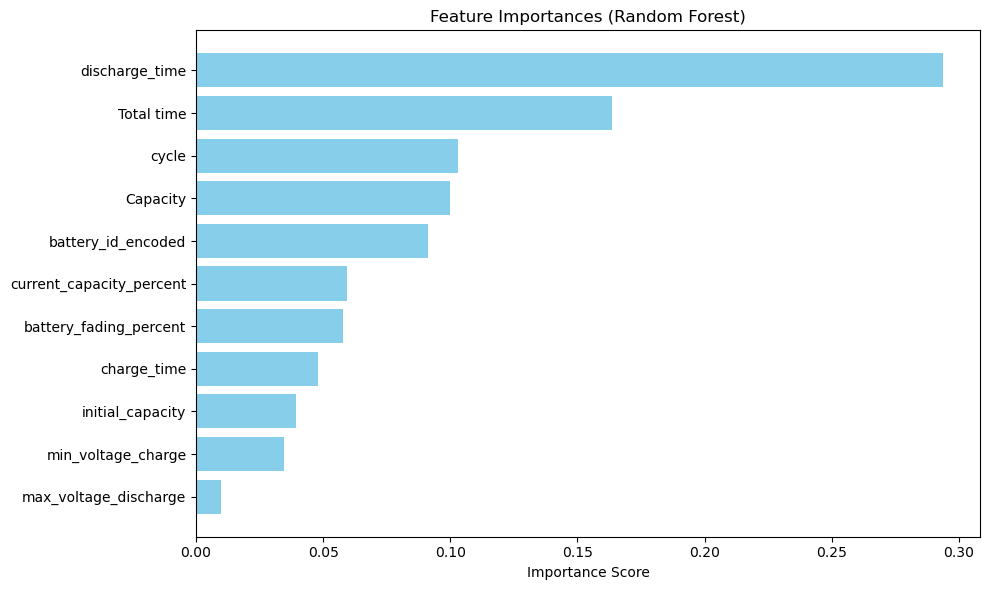

In [23]:
importances = best_rf.feature_importances_
feature_names = X_train.columns  # Assumes you're using a DataFrame

# Create a DataFrame for better display
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print(importance_df)

# Optional: plot it
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [25]:
# Train model
rf_model = RandomForestRegressor(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)

print(f"R² Score: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")

R² Score: 0.985
Mean Squared Error: 32.327


import pickle

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

In [26]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Step 2: Set up hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}


In [28]:
# Step 3: Initialize GridSearchCV with SVR
grid_search = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

In [29]:
# Step 4: Fit the model
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 0.2, 0.5],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1]},
             scoring='r2', verbose=1)

In [30]:
# Step 5: Predict and evaluate
best_svr = grid_search.best_estimator_
svr_preds = best_svr.predict(X_test_scaled)
svr_r2 = r2_score(y_test, svr_preds)
svr_mse = mean_squared_error(y_test, svr_preds)

In [31]:
print("Best Parameters:", grid_search.best_params_)
print(f"SVR R² Score: {svr_r2:.3f}")
print(f"SVR Mean Squared Error: {svr_mse:.3f}")

Best Parameters: {'C': 1000, 'epsilon': 0.2, 'gamma': 1}
SVR R² Score: 0.990
SVR Mean Squared Error: 21.392


import pickle

with open("svr.pkl", "wb") as f:
    pickle.dump(best_svr, f)

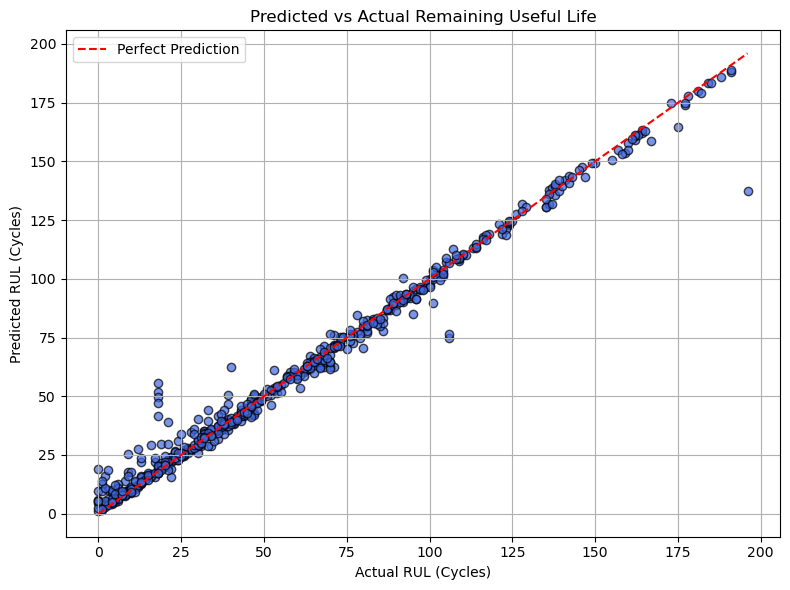

In [32]:
import matplotlib.pyplot as plt

# Create the DataFrame
plot_df = pd.DataFrame({
    'Actual RUL': y_test.values,
    'Predicted RUL': preds
})

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(plot_df['Actual RUL'], plot_df['Predicted RUL'], alpha=0.7, color='royalblue', edgecolor='black')
plt.plot([plot_df['Actual RUL'].min(), plot_df['Actual RUL'].max()],
         [plot_df['Actual RUL'].min(), plot_df['Actual RUL'].max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.title("Predicted vs Actual Remaining Useful Life")
plt.xlabel("Actual RUL (Cycles)")
plt.ylabel("Predicted RUL (Cycles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Optional: Scale only for models that need it
models = {
    "Support vector Regressor": make_pipeline(StandardScaler(), SVR(C=1000, epsilon=0.2, gamma=1)),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=300, max_depth=20, max_features='sqrt',
        min_samples_split=2, min_samples_leaf=1, random_state=42),
    "KNN Regressor": make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3)),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42),    
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": make_pipeline(StandardScaler(), LinearRegression())
}

In [34]:
# Add simple color formatting
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'

# Training and evaluating
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    results[name] = {"r2": r2, "mse": mse}
    
    print(f"\n{bcolors.HEADER}{bcolors.BOLD}{name}{bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}R² Score: {r2:.3f}{bcolors.ENDC}")
    print(f"{bcolors.OKBLUE}Mean Squared Error: {mse:.3f}{bcolors.ENDC}")


Support vector Regressor
R² Score: 0.990
Mean Squared Error: 21.392

Random Forest Regressor
R² Score: 0.982
Mean Squared Error: 37.286

KNN Regressor
R² Score: 0.976
Mean Squared Error: 49.952

Gradient Boosting
R² Score: 0.967
Mean Squared Error: 69.011

Decision Tree
R² Score: 0.916
Mean Squared Error: 176.103

Linear Regression
R² Score: 0.357
Mean Squared Error: 1353.597


In [35]:
#!pip install colorama

In [36]:
results = {}

# Fit and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    results[name] = {"r2": r2, "mse": mse}

In [37]:
# Sort results by R² score (ascending)
sorted_results = sorted(results.items(), key=lambda x: x[1]['r2'],reverse=True)

# Print with formatting and color
print(f"\n{bcolors.BOLD}{'Model':<25} {'R² Score':<15} {'MSE':<15}{bcolors.ENDC}")
print(f"{'-'*55}")

for name, metrics in sorted_results:
    print(f"{bcolors.HEADER}{name:<25}{bcolors.ENDC}"
          f"{bcolors.OKGREEN}{metrics['r2']:<15.3f}{bcolors.ENDC}"
          f"{bcolors.OKBLUE}{metrics['mse']:<15.3f}{bcolors.ENDC}")


Model                     R² Score        MSE            
-------------------------------------------------------
Support vector Regressor 0.990          21.392         
Random Forest Regressor  0.982          37.286         
KNN Regressor            0.976          49.952         
Gradient Boosting        0.967          69.011         
Decision Tree            0.916          176.103        
Linear Regression        0.357          1353.597       
